In [1]:
from torchvision.transforms import v2 as transforms

import lightning as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger

from keyrover import *
from keyrover.vision import *
from keyrover.vision.models import CornersRegressionModel
from keyrover.datasets import KeyboardCornersDataset
from keyrover.math.bilinear import InterpolateQuad

import wandb

wandb.login()
device

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bhavye-mathur. Use `wandb login --relogin` to force relogin


'mps'

In [2]:
SIZE = (256, 256)

train_dataset, valid_dataset, test_dataset = KeyboardCornersDataset.load("v4-nodistort", size=SIZE)
len(train_dataset), len(valid_dataset), len(test_dataset)

100%|██████████| 500/500 [00:00<00:00, 700.55it/s]


(4000, 499, 500)

<class 'torch.Tensor'> (torch.float32, shape=torch.Size([3, 256, 256]))
        Min: -1.322045087814331
        Max: 1.9681987762451172
        Mean: -0.32203176617622375


tensor([[-129.1064,  518.8760,  641.4270,  181.0568,  537.1118, -105.4656,
         -223.6262,  220.8018]])

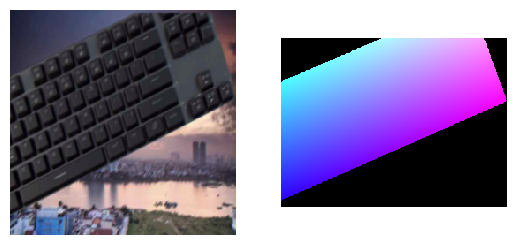

In [3]:
train_dataset.set_transforms([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomAffine(degrees=30, shear=30, translate=(0.25, 0.25)),
    # transforms.RandomPerspective(distortion_scale=0.25, p=0.5),
])

train_dataset.set_input_augmentations([
    # transforms.GaussianNoise(sigma=0.1, clip=True),
    # transforms.RandomApply([transforms.GaussianNoise(sigma=0.1, clip=False)], p=0.5),
], norm_params="default")

transform = InterpolateQuad(1, width=640, height=480, device=device)

img, corners = train_dataset.random_img()
corners = train_dataset.denormalize(corners)
mask = transform(corners)[0]

imshow(img, mask)
describe(img)

train_dataloader, valid_dataloader, test_dataloader = create_dataloaders(train_dataset, valid_dataset, test_dataset,
                                                                         batch_size=64, num_workers=2,
                                                                         persistent_workers=True, pin_memory=True)
corners

In [4]:
wandb.finish()
model = CornersRegressionModel(lr=4e-4)
model

CornersRegressionModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [5]:
summarize(model)

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | ResNet  | 11.3 M | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.302    Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode

In [ ]:
logger = WandbLogger(project="mrover-keyboard-corner-prediction")

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(log_every_n_steps=1, logger=logger, max_time="00:08:00:00", callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

In [ ]:
model.save(f"{wandb.run.name}.pt")

In [4]:
model = CornersRegressionModel.load("magic-wave-28.pt")

(<Axes: >, <Axes: >)

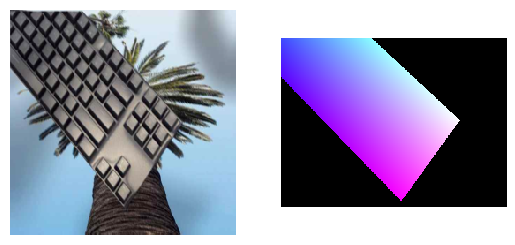

In [5]:
model.to(device)
model.eval()

img, corners = valid_dataset.random_img()
imshow(img, model.predict(img))

(<Axes: >, <Axes: >)

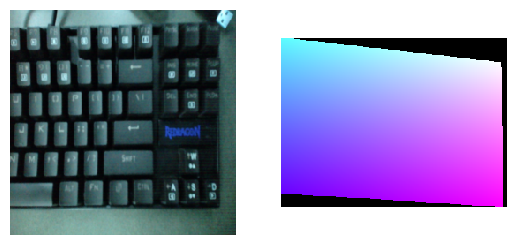

In [11]:
img = test_dataset.load_image(f"{DATASETS}/test/2.jpg")
imshow(img, model.predict(img))